# 통신사 고객 이탈 예측 

### 목적
* 파악한 특성들을 이용하여 기대 가치가 큰 고객의 이탈 징후를 잘 탐지하는 예측 모델 생성.
[참고](https://brunch.co.kr/@gimmesilver/53)
    - 예측 모델의 목표는 오차를 최소화하는 것이 아니다.
        - 실제 서비스에서 예측 모델을 사용하는 본질적인 목적은 정답을 잘 맞추겠다가 아니라 예측 모델을 실전에 적용함으로써 이익을 얻는 것. 
        - 따라서, 실제 예측 모델이 목표로 해야할 것은 오차를 최소화하는 것이 아니라 모델 적용을 통해 기대되는 이익을 최대화하는 것. 
        
### 문제 정의
* 지도학습, 분류

### 성능 지표
* 재현율
    * 실제 이탈하는 사람 중 이탈이라고 예측하는 것이 중요하기 때문.
    * 실제 이탈하지 않은 사람을 이탈이라고 예측하면 회사 측에서 손해액 발생

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder  # 더미변수 생성 
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # 분류
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns


In [2]:
pd.set_option('display.max_columns', 500)

df = pd.read_csv("../../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.shape

(7043, 21)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype("object")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"],errors = "coerce")

In [6]:
df.select_dtypes(include=[np.object]).describe()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,3824-RHKVR,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [7]:
df.select_dtypes(include=[np.number]).describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


array([[<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>],
       [<AxesSubplot:title={'center':'TotalCharges'}>, <AxesSubplot:>]],
      dtype=object)

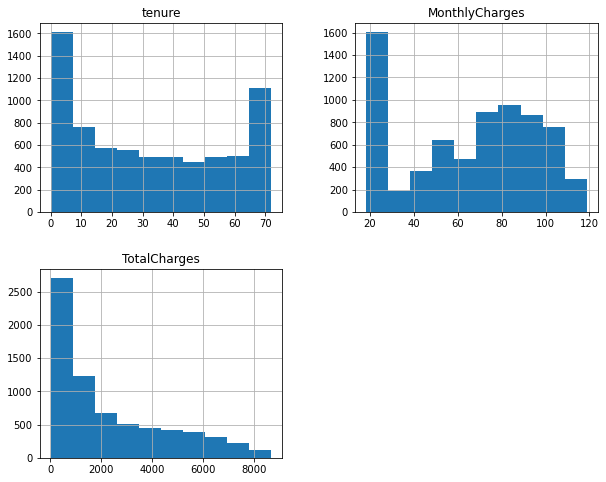

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(figsize = (10,8),bins = 10)

In [9]:
df = df[df["tenure"]!=0].reset_index(drop=True)

<AxesSubplot:>

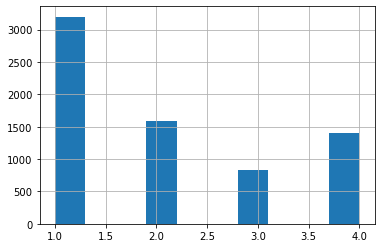

In [10]:
df["tenure_cat"] = pd.cut(df["tenure"], bins = [0, 24,48,60,72], labels = [1,2,3,4])
df["tenure_cat"].hist()

In [11]:
df["tenure_cat"].value_counts()

1    3199
2    1594
4    1407
3     832
Name: tenure_cat, dtype: int64

In [12]:
df["tenure_cat"].isnull().sum()

0

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 20171490)

for train_index, test_index in split.split(df, df["tenure_cat"]):
    X_train = df.loc[train_index]
    X_test = df.loc[test_index]

In [14]:
X_train["tenure_cat"].value_counts()/len(X_train)

1    0.454933
2    0.226667
4    0.200000
3    0.118400
Name: tenure_cat, dtype: float64

In [15]:
X_test["tenure_cat"].value_counts()/len(X_test)

1    0.454869
2    0.226724
4    0.200426
3    0.117982
Name: tenure_cat, dtype: float64

In [16]:
for set_ in (X_train, X_test):
    set_.drop("tenure_cat",axis = 1, inplace = True)

In [17]:
X_train

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3131,3884-HCSWG,Female,0,No,No,17,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.00,1144.50,Yes
1353,9272-LSVYH,Male,0,No,No,10,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,70.15,735.50,No
3866,7340-KEFQE,Female,0,Yes,Yes,51,No,No phone service,DSL,Yes,No,No,Yes,No,No,Two year,No,Bank transfer (automatic),34.20,1782.00,No
5814,9867-NNXLC,Female,0,No,No,22,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.05,470.20,No
3578,9552-TGUZV,Male,0,Yes,No,8,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,75.00,658.10,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3027,5696-EXCYS,Male,0,No,No,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.45,369.05,No
314,7563-BIUPC,Male,0,No,No,5,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.60,415.55,Yes
887,7549-MYGPK,Female,0,Yes,Yes,63,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,100.55,6215.35,Yes
3926,5396-IZEPB,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.70,180.70,No


In [18]:
data = X_train.copy()

In [19]:
data['Churn_b'] = data['Churn'].astype('category').cat.rename_categories([0,1])

In [20]:
from scipy import stats

# Convert attrition to numeric
num_features = list(data.select_dtypes(include=[np.number]))

# Point Biserial Correlation table
pb_list = []
print("Significant Point Biserial Correlations")
print("{0:23} |   {1:4}|  {2:}".format("Factor", "r", "p"))
for i in num_features:
    r, p = stats.pointbiserialr(data['Churn_b'], data[i])
    if p < .01:
        print("{0:23} | {1:5.2f} | {2:.2f}".format(i, r, p))
        pb_list.append(i)

Significant Point Biserial Correlations
Factor                  |   r   |  p
tenure                  | -0.35 | 0.00
MonthlyCharges          |  0.19 | 0.00
TotalCharges            | -0.20 | 0.00


<AxesSubplot:>

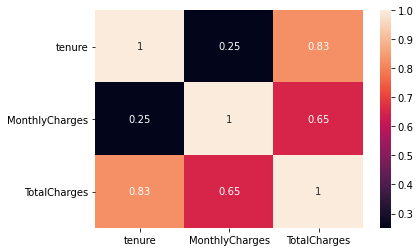

In [21]:
sns.heatmap(data.corr(), annot = True)

In [22]:
# from statsmodels.formula.api import ols

# model = ols('Churn ~ tenure +TotalCharges+MonthlyCharges', data)
# res = model.fit()
# res.summary()

In [23]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
#              for i, column in enumerate(model.exog_names)
#              if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

In [24]:
cat_list = list(data.select_dtypes(include =['object']))
cat_list

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

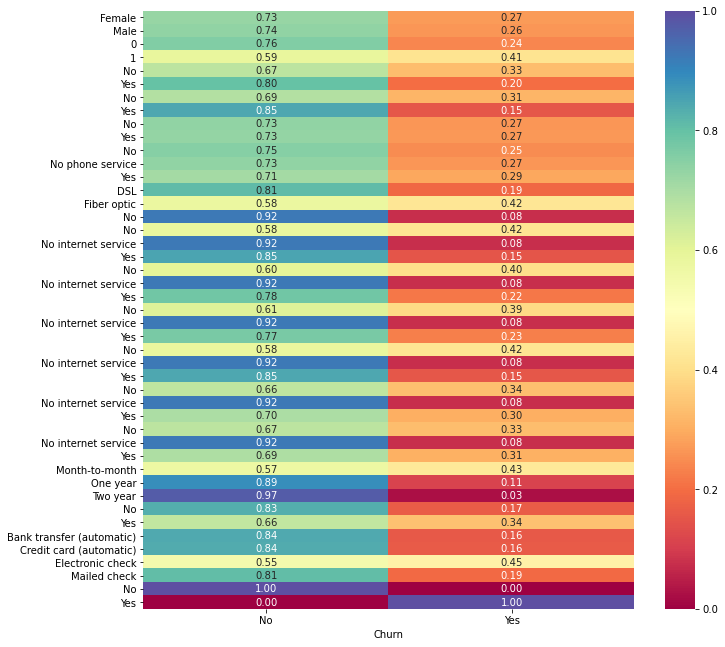

In [25]:
att_by_cat = pd.crosstab(data.Churn, data.gender, normalize='columns')

for i in cat_list[2:]:
    t = pd.crosstab(data.Churn, data[i], normalize='columns')
    att_by_cat = pd.concat((att_by_cat, t), axis=1)
    
f, a = plt.subplots(figsize=(11, 11))
heat = sns.heatmap(att_by_cat.transpose(), annot=True, fmt=".2f", center=.5, cmap="Spectral")

In [26]:
X = X_train.drop(["Churn"],axis = 1)
y = X_train["Churn"]

y.replace("No",0,inplace = True)
y.replace("Yes",1,inplace = True)

In [27]:
y.value_counts()/len(y)

0    0.733156
1    0.266844
Name: Churn, dtype: float64

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify = y,test_size = 0.2, shuffle = True, random_state = 20171490)

In [29]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(4500, 20)
(1125, 20)
(4500,)
(1125,)


In [30]:
print(y_train.value_counts()/len(y_train))
print(y_valid.value_counts()/len(y_valid))

0    0.733111
1    0.266889
Name: Churn, dtype: float64
0    0.733333
1    0.266667
Name: Churn, dtype: float64


In [31]:
print(y_train.value_counts())
print(y_valid.value_counts())

0    3299
1    1201
Name: Churn, dtype: int64
0    825
1    300
Name: Churn, dtype: int64


In [32]:
cate_features2 = []
cate_features_not2 = []

for column in X_train.columns:
    if X_train[column].dtypes==object:
        if len(X_train[column].value_counts())==2:
            cate_features2.append(column)
        else:
            cate_features_not2.append(column)
        
print(cate_features2)
print(cate_features_not2)

cate_features_not2.remove("customerID")

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [33]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [34]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["tenure","TotalCharges","MonthlyCharges"])),
        ('scaler', RobustScaler()),
    ])

cate_1hot_pipeline = Pipeline([
        ("select_cate_1hot", DataFrameSelector(cate_features_not2)),
        ('1hot', OneHotEncoder(sparse=False)),  # sparse=False 밀집행렬로 만들어야함. 
    ])

cate_ord_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(cate_features2)),
        ('ordinary', OrdinalEncoder()),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_pipeline)])

X_prepared = preprocess_pipeline.fit_transform(X_train)

In [35]:
pd.DataFrame(X_prepared)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.914894,1.692905,0.487220,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,0.382979,-0.132256,-0.902511,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.893617,1.447515,0.273694,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3,-0.595745,-0.384929,0.284551,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
4,-0.191489,0.143799,0.339742,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-0.595745,-0.395617,-0.371409,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4496,-0.382979,-0.146939,0.287265,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4497,0.914894,1.571072,0.397648,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4498,0.127660,0.593197,0.478172,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


#### 파이프라인 적용 후 feature 확인

In [36]:
feature_names = cate_1hot_pipeline.named_steps["1hot"]
feature_names.categories_

[array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object)]

In [37]:
feature_names = cate_1hot_pipeline.named_steps["1hot"]
feature_names.categories_

cat_one_hot_features = []

i = 0

for feature in cate_features_not2:
        
    cat_one_hot_features.append([feature+"_"+string for string in list(feature_names.categories_[i])])    

    i += 1
    
cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features =  num_features+cat_one_hot_features+ cate_features2 
print()
print(len(features))

['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

40


In [38]:
X_prepared.shape

(4500, 40)

### 여러 모델 적용하여 비교하기 

In [39]:
models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","Ada","XGB"]

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
cv_mo = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 20171490)

acc = []
precision = []
recall = []
roc = []

for model, name in zip(models, names):
    print(name)
    cv_predict = cross_val_predict(model, X_prepared, y_train,cv=cv_mo)

    acc.append(accuracy_score(y_train, cv_predict))
    precision.append(precision_score(y_train,cv_predict))
    recall.append(recall_score(y_train,cv_predict))
    roc.append(roc_auc_score(y_train, cv_predict))
    
pd.DataFrame({"Model":names, "Accuracy":acc, "Precision":precision, "Recall":recall, "AUC":roc})

Logistic
RF
Ada
XGB
[20:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:59] WARNING: C:/Users/Administrator/workspa

,Model,Accuracy,Precision,Recall,AUC
0,Logistic,0.808889,0.668645,0.562864,0.730659
1,RF,0.797333,0.655544,0.507077,0.705039
2,Ada,0.806889,0.667339,0.551207,0.725589
3,XGB,0.790444,0.630040,0.520400,0.704577


AdaBoost와 Logistic의 성능이 가장 좋음

#### 랜덤포레스트기로 중요 변수 확인

In [41]:
feature_importances = pd.DataFrame(RandomForestClassifier().fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
MonthlyCharges,0.168778
tenure,0.144901
TotalCharges,0.140511
Contract_Month-to-month,0.051124
TechSupport_No,0.034248
PaymentMethod_Electronic check,0.029920
OnlineSecurity_No,0.029190
InternetService_Fiber optic,0.028660
gender,0.026776
PaperlessBilling,0.025230


<AxesSubplot:xlabel='importance'>

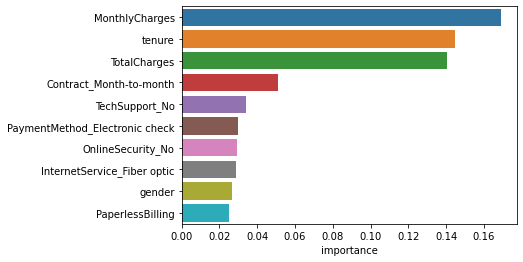

In [42]:
sns.barplot(feature_importances["importance"],feature_importances.index)

#### 보조 서비스 가입 개수 변수 추가하기
보조서비스 종류: OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport   
스트리밍: StreamingTV, StreamingMovies

In [43]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names): # *args 또는 **kargs 없음
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        
        df = X[self.attribute_names]
        df.replace("Yes",1,inplace=True)
        df.replace("No",0,inplace=True)
        df.replace("No internet service",0,inplace=True)
    
        df["SupplementaryService"] = df["OnlineSecurity"]+df["OnlineBackup"]+df["DeviceProtection"]+df["TechSupport"]
        df["Streaming"] = df["StreamingTV"]+df["StreamingMovies"]

        return df.drop(self.attribute_names, axis = 1)

In [44]:
col_names = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
df_extra_attribs = CombinedAttributesAdder(col_names)
df_extra_attribs.transform(X_train)

,SupplementaryService,Streaming
4816,1,2
1695,0,0
2384,3,2
2740,0,1
6791,1,1
...,...,...
1938,0,0
5138,0,1
6650,4,2
5089,4,0


In [45]:
data["PaymentMethod"].value_counts()

Electronic check             1893
Mailed check                 1281
Bank transfer (automatic)    1233
Credit card (automatic)      1218
Name: PaymentMethod, dtype: int64

In [46]:
data["Contract"].value_counts()

Month-to-month    3100
Two year          1318
One year          1207
Name: Contract, dtype: int64

In [94]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["tenure", "MonthlyCharges","TotalCharges"])),
        ('scaler', RobustScaler()),
    ])

cate_1hot_pipeline = Pipeline([
        ("select_cate_1hot", DataFrameSelector(['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'])),
        ('1hot', OneHotEncoder(sparse=False)),  # sparse=False 밀집행렬로 만들어야함. 
    ])

cate_ord_no_cor_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(['SeniorCitizen', 'Partner', 'Dependents','PaperlessBilling'])),
        # ("select_cate_ord", DataFrameSelector(cate_features2)),

        ('ordinary', OrdinalEncoder()),
    ])

cate_ord_pipeline = Pipeline([
        ("select_cate_ord", DataFrameSelector(cate_features2)),

        ('ordinary', OrdinalEncoder()),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ('attribs_adder', CombinedAttributesAdder(col_names)),
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_pipeline)])

preprocess_no_pipeline = FeatureUnion(transformer_list=[
        ('attribs_adder', CombinedAttributesAdder(col_names)),
        ("num_pipeline", num_pipeline),
        ("cat_1hot_pipeline", cate_1hot_pipeline),
        ("cat_ord_pipeline", cate_ord_no_cor_pipeline)])

X_prepared = preprocess_pipeline.fit_transform(X_train)
X_prepared_no = preprocess_no_pipeline.fit_transform(X_train)

In [95]:
print(X_prepared.shape)
print(X_prepared_no.shape)

(4500, 24)
(4500, 22)


In [96]:
X_valid_prepared = preprocess_pipeline.fit_transform(X_valid)
X_valid_prepared_no = preprocess_no_pipeline.fit_transform(X_valid)

In [97]:
def Modeling_result(train_x, train_y, valid_x, valid_y):
    
    models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier()]
    names = ["Logistic","RF","Ada","XGB"]

    train_acc = []
    train_precision = []
    train_recall = []
    train_roc = []

    valid_acc = []
    valid_precision = []
    valid_recall = []
    valid_roc = []


    for model, name in zip(models, names):

        model.fit(train_x,train_y)
        model.predict(valid_x)

        train_acc.append(accuracy_score(train_y,model.predict(train_x)))
        train_precision.append(precision_score(train_y,model.predict(train_x)))
        train_recall.append(recall_score(train_y,model.predict(train_x)))
        train_roc.append(roc_auc_score(train_y, model.predict(train_x)))

        valid_acc.append(accuracy_score(valid_y, model.predict(valid_x)))
        valid_precision.append(precision_score(valid_y,model.predict(valid_x)))
        valid_recall.append(recall_score(valid_y,model.predict(valid_x)))
        valid_roc.append(roc_auc_score(valid_y, model.predict(valid_x)))
        
    return pd.DataFrame({"Model":names, "Train_Accuracy":train_acc, "Train_Precision":train_precision, "Train_Recall":train_recall, "Train_AUC":train_roc,
             "Valid_Accuracy":valid_acc, "Valid_Precision":valid_precision, "Valid_Recall":valid_recall, "Valid_AUC":valid_roc})


In [98]:
gender_right = Modeling_result(X_prepared, y_train, X_valid_prepared, y_valid)
gender_right

[20:52:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.810889,0.675351,0.561199,0.731494,0.794667,0.633205,0.546667,0.715758
1,RF,0.998444,0.998331,0.995837,0.997615,0.778667,0.608511,0.476667,0.682576
2,Ada,0.812222,0.684647,0.549542,0.728696,0.767111,0.562914,0.566667,0.703333
3,XGB,0.950222,0.943688,0.865112,0.923159,0.773333,0.588235,0.500000,0.686364


In [99]:
no_cor_result = Modeling_result(X_prepared_no, y_train, X_valid_prepared_no, y_valid)
no_cor_result

[20:52:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.811333,0.677778,0.558701,0.731003,0.792889,0.631373,0.536667,0.711364
1,RF,0.998222,0.997498,0.995837,0.997464,0.768000,0.577689,0.483333,0.677424
2,Ada,0.812222,0.684647,0.549542,0.728696,0.767111,0.562914,0.566667,0.703333
3,XGB,0.937333,0.923502,0.834305,0.904573,0.776000,0.594488,0.503333,0.689242


* RF와 XG는 과대적합이 발생함.
    * feature 수를 줄이거나 규제를 줄인다. -> feature 수 줄이는 것을 선택 
    * gender, PhoneService 변수는 독립성 검정 시 상관없는 변수이기 때문에 제외해본 결과 검증 셋에 더 좋은 성능을 띈다.
    
* Logistic, Ada를 대상으로 교차검증을 적용


#### Logisitc, AdaBoost 모델 교차 검증 적용하기

In [100]:
cv_mo = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 20171490)

cv_predict = cross_val_predict(LogisticRegression(), preprocess_pipeline.fit_transform(X), y,cv=cv_mo)
print(classification_report(y, cv_predict))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4124
           1       0.66      0.55      0.60      1501

    accuracy                           0.81      5625
   macro avg       0.76      0.72      0.74      5625
weighted avg       0.80      0.81      0.80      5625



In [101]:
cv_predict = cross_val_predict(AdaBoostClassifier(), preprocess_pipeline.fit_transform(X), y,cv=cv_mo)
print(classification_report(y, cv_predict))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4124
           1       0.67      0.53      0.59      1501

    accuracy                           0.80      5625
   macro avg       0.75      0.72      0.73      5625
weighted avg       0.80      0.80      0.80      5625



Recall 의 성능이 너무 낮음.

### 데이터 불균형 해소

In [113]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 20171490)

X_res_train, y_res_train = sm.fit_sample(X_prepared_no, y_train)
print(y_train.value_counts(), np.bincount(y_res))

0    3299
1    1201
Name: Churn, dtype: int64 [4124 4124]


In [114]:
upsampling_result = Modeling_result(X_res_train, y_res_train, X_valid_prepared_no, y_valid)
upsampling_result

[21:12:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Train_Accuracy,Train_Precision,Train_Recall,Train_AUC,Valid_Accuracy,Valid_Precision,Valid_Recall,Valid_AUC
0,Logistic,0.772658,0.753309,0.810852,0.772658,0.728889,0.494759,0.786667,0.747273
1,RF,0.998788,0.998485,0.999091,0.998788,0.756444,0.540625,0.576667,0.699242
2,Ada,0.805850,0.785998,0.840558,0.805850,0.727111,0.492170,0.733333,0.729091
3,XGB,0.948772,0.944194,0.953925,0.948772,0.734222,0.501326,0.630000,0.701061


전체 train 데이터를 대상으로 교차 검증

In [105]:
X_res, y_res = sm.fit_sample(preprocess_pipeline.fit_transform(X), y)
print(y_train.value_counts(), np.bincount(y_res))

0    3299
1    1201
Name: Churn, dtype: int64 [4124 4124]


In [109]:
models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","Ada","XGB"]
cv_scores = []

acc = []
precision = []
recall = []
roc = []

for model, name in zip(models, names):
    print(name)
    start = time.time()
    
    # method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
    cv_predict = cross_val_predict(model, X_res, y_res, cv=10)
    cv_scores.append(cross_val_score(model, X_res, y_res, cv=10,scoring='roc_auc'))

    acc.append(accuracy_score(y_res, cv_predict))
    precision.append(precision_score(y_res,cv_predict))
    recall.append(recall_score(y_res,cv_predict))
    roc.append(roc_auc_score(y_res, cv_predict))
    
pd.DataFrame({"Model":names, "Accuracy":acc, "Precision":precision, "Recall":recall, "AUC":roc})

Logistic
RF
Ada
XGB
[21:02:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:45] WARNING: C:/Users/Administrator/workspa

,Model,Accuracy,Precision,Recall,AUC
0,Logistic,0.772672,0.751510,0.814743,0.772672
1,RF,0.855238,0.843091,0.872939,0.855238
2,Ada,0.813652,0.789698,0.854995,0.813652
3,XGB,0.845296,0.845631,0.844811,0.845296


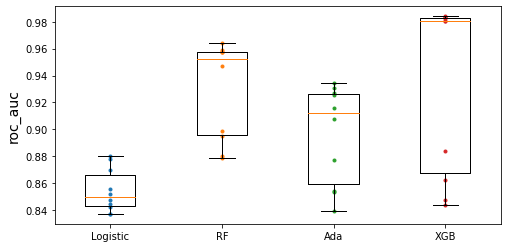

In [110]:
plt.figure(figsize=(8, 4))

i = 1

for cv_score in cv_scores:
    
    plt.plot([i]*10, cv_score, ".")
    
    i+=1
    
plt.boxplot(cv_scores, labels=("Logistic","RF","Ada","XGB"))
plt.ylabel("roc_auc", fontsize=14)
plt.show()

#### RandomForest grid search

In [115]:
param_grid_RF = {
    "n_estimators" :[10,15,20,25], 
    "max_depth" : [5,10,15],
    "min_samples_split":[2,4,8,16],
    "max_features":["sqrt","auto","log2"],
    "class_weight" : ["balanced_subsample","balanced"]}

cv_RF_roc = GridSearchCV(RandomForestClassifier(),param_grid_RF, cv= cv_mo, scoring = "roc_auc",return_train_score=True)
cv_RF_roc.fit(X_res_train, y_res_train)
cv_RF_best = cv_RF_roc.best_estimator_

In [116]:
cv_RF_roc.best_params_

{'class_weight': 'balanced_subsample',
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 25}

In [125]:
param = cv_RF_roc.best_params_
model_RF = RandomForestClassifier(max_depth = 10, max_features = 'log2', min_samples_split = 2, n_estimators = 50)
model_RF.fit(X_res_train, y_res_train)
print(confusion_matrix(y_res_train,model_RF.predict(X_res_train)))
print(classification_report(y_res_train,model_RF.predict(X_res_train)))

print(confusion_matrix(y_valid,model_RF.predict(X_valid_prepared_no)))
print(classification_report(y_valid,model_RF.predict(X_valid_prepared_no)))

[[2742  557]
 [ 197 3102]]
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      3299
           1       0.85      0.94      0.89      3299

    accuracy                           0.89      6598
   macro avg       0.89      0.89      0.89      6598
weighted avg       0.89      0.89      0.89      6598

[[631 194]
 [ 86 214]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       825
           1       0.52      0.71      0.60       300

    accuracy                           0.75      1125
   macro avg       0.70      0.74      0.71      1125
weighted avg       0.79      0.75      0.76      1125



In [126]:
param = cv_RF_roc.best_params_
model_RF = RandomForestClassifier(max_depth = 8, max_features = 'log2', min_samples_split = 4, n_estimators = 50)

model_RF.fit(X_res_train, y_res_train)
print(confusion_matrix(y_res_train,model_RF.predict(X_res_train)))
print(classification_report(y_res_train,model_RF.predict(X_res_train)))
00
print(confusion_matrix(y_valid,model_RF.predict(X_valid_prepared_no)))
print(classification_report(y_valid,model_RF.predict(X_valid_prepared_no)))

[[2592  707]
 [ 311 2988]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3299
           1       0.81      0.91      0.85      3299

    accuracy                           0.85      6598
   macro avg       0.85      0.85      0.85      6598
weighted avg       0.85      0.85      0.85      6598

[[627 198]
 [ 77 223]]
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       825
           1       0.53      0.74      0.62       300

    accuracy                           0.76      1125
   macro avg       0.71      0.75      0.72      1125
weighted avg       0.79      0.76      0.77      1125



In [128]:
model_Ada = AdaBoostClassifier(base_estimator = cv_RF_best)
model_Ada.fit(X_res_train, y_res_train)
print(confusion_matrix(y_valid,model_Ada.predict(X_valid_prepared_no)))
print(classification_report(y_valid,model_Ada.predict(X_valid_prepared_no)))

[[677 148]
 [125 175]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       825
           1       0.54      0.58      0.56       300

    accuracy                           0.76      1125
   macro avg       0.69      0.70      0.70      1125
weighted avg       0.76      0.76      0.76      1125



* 검증 데이터에서의 결과가 새로운 데이터에 적용하기에 만족스럽지 않기 때문에 AutoML을 적용해봄.

### AutoMl 적용

In [136]:
from pycaret.classification import *

pycaret는 기존에 있던 sklearn, XGBoost, LigthGBM, spaCy 등 여러가지 머신러닝 라이브러리를 사용하기 용이하도록 제적한 라이브러리.

In [133]:
ml_data = pd.concat([pd.DataFrame(X_res_train),y_res_train],axis=1)

In [134]:
ml_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,Churn
0,1.000000,2.0,0.914894,0.487220,1.692905,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.000000,0.0,1.000000,0
1,0.000000,0.0,0.382979,-0.902511,-0.132256,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0
2,3.000000,2.0,0.893617,0.273694,1.447515,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,1.0,0.000000,0
3,0.000000,1.0,-0.595745,0.284551,-0.384929,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.0,1.000000,1
4,1.000000,1.0,-0.191489,0.339742,0.143799,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,0.000000,0.0,-0.511466,0.076772,-0.306628,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.0,1.000000,1
6594,1.000000,0.0,-0.375823,-0.733452,-0.312282,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.768435,1.0,0.000000,1
6595,1.000000,0.0,-0.550188,0.067022,-0.344922,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,1.000000,1
6596,0.000000,0.0,-0.595745,-0.822187,-0.402962,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.252513,1


In [137]:
# setup 메서들릇 ㅏ용하여 데이터에 대한 여러가지 머신러닝 기법 사용 가능
# 객체 선언 후 실행한 후 ENRTER를 누름. 
clf = setup(data = ml_data, target = "Churn")

,Description,Value
0,session_id,2861
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(6598, 23)"
5,Missing Values,False
6,Numeric Features,22
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# model()  # 사용가능한 머신러닝 모델 확인 가능 
# 파라미터 이름, 머신러닝 기법이름, 사이킷런 API 사용 여부 등 
# create_model('lr')  # LinearRegression 모델 생성 
# tune_model()  # 생성한 모델 튜닝 

In [138]:
best_3 = compare_models(sort = 'AUC', n_select = 3)  # 모델 성능 비교 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8525,0.9322,0.8633,0.8431,0.8529,0.7051,0.7055,5.4760
lightgbm,Light Gradient Boosting Machine,0.8478,0.9270,0.8615,0.8364,0.8487,0.6956,0.6960,0.1920
xgboost,Extreme Gradient Boosting,0.8452,0.9249,0.8545,0.8367,0.8454,0.6904,0.6908,0.4900
et,Extra Trees Classifier,0.8460,0.9188,0.8584,0.8355,0.8468,0.6921,0.6925,0.3020
rf,Random Forest Classifier,0.8389,0.9166,0.8502,0.8293,0.8395,0.6778,0.6782,0.3090
gbc,Gradient Boosting Classifier,0.8322,0.9146,0.8619,0.8113,0.8358,0.6645,0.6659,0.1910
ada,Ada Boost Classifier,0.8066,0.8913,0.8397,0.7853,0.8114,0.6135,0.6152,0.0920
knn,K Neighbors Classifier,0.7876,0.8631,0.8785,0.7414,0.8039,0.5758,0.5862,0.0720
lr,Logistic Regression,0.7702,0.8576,0.7999,0.7527,0.7754,0.5407,0.5420,1.5850
lda,Linear Discriminant Analysis,0.7698,0.8537,0.8004,0.7518,0.7751,0.5399,0.5413,0.0160


In [139]:
# tune top 5 base models
tuned_top3 = [tune_model(i) for i in best_3]
tuned_top3

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8312,0.9238,0.9127,0.7828,0.8427,0.6628,0.6719
1,0.7987,0.8906,0.8646,0.7615,0.8098,0.5978,0.6033
2,0.8355,0.9192,0.9170,0.7865,0.8468,0.6714,0.6807
3,0.8160,0.9121,0.8952,0.7707,0.8283,0.6325,0.6408
4,0.7922,0.9020,0.8908,0.7418,0.8095,0.5851,0.5970
5,0.8247,0.9074,0.8952,0.7824,0.8350,0.6498,0.6565
6,0.8333,0.9210,0.9258,0.7794,0.8463,0.6672,0.6790
7,0.8312,0.9158,0.8908,0.7938,0.8395,0.6627,0.6676
8,0.8243,0.9061,0.8952,0.7824,0.8350,0.6489,0.6556
9,0.8438,0.9229,0.9035,0.8047,0.8512,0.6880,0.6931


 LGBMClassifier(bagging_fraction=1.0, bagging_freq=4, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
                importance_type='split', learning_rate=0.432, max_depth=-1,
                min_child_samples=25, min_child_weight=0.001, min_split_gain=0,
                n_estimators=200, n_jobs=-1, num_leaves=100, objective=None,
                random_state=2861, reg_alpha=0.4, reg_lambda=0.0005, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.379, max_delta_step=0, max_depth=7,
               min_child_weight=2, missing=nan, monotone_constraints='()',
               n_estimators=250, n_jobs=-1, num_parallel_tree=1,
               objective='binary:

In [140]:
bagged_top3 = [ensemble_model(i) for i in tuned_top3]  # 배깅 방법으로 앙상블 적용 
bagged_top3

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8398,0.9270,0.9214,0.7903,0.8508,0.6801,0.6895
1,0.8139,0.9014,0.8777,0.7761,0.8238,0.6281,0.6334
2,0.8506,0.9227,0.9301,0.8008,0.8606,0.7017,0.7108
3,0.8442,0.9227,0.9083,0.8031,0.8525,0.6886,0.6945
4,0.8203,0.9171,0.9039,0.7724,0.8330,0.6412,0.6505
5,0.8312,0.9164,0.9039,0.7871,0.8415,0.6627,0.6700
6,0.8333,0.9257,0.9083,0.7879,0.8438,0.6671,0.6749
7,0.8528,0.9285,0.9039,0.8182,0.8589,0.7059,0.7097
8,0.8178,0.9065,0.9039,0.7695,0.8313,0.6360,0.6457
9,0.8503,0.9193,0.9211,0.8046,0.8589,0.7011,0.7084


[BaggingClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x0000019A3F49E9C8>,
                   bootstrap=True, bootstrap_features=False, max_features=1.0,
                   max_samples=1.0, n_estimators=10, n_jobs=None,
                   oob_score=False, random_state=2861, verbose=0,
                   warm_start=False),
 BaggingClassifier(base_estimator=LGBMClassifier(bagging_fraction=1.0,
                                                 bagging_freq=4,
                                                 boosting_type='gbdt',
                                                 class_weight=None,
                                                 colsample_bytree=1.0,
                                                 feature_fraction=0.4,
                                                 importance_type='split',
                                                 learning_rate=0.432,
                                                 max_depth=-1,
                            

In [146]:
# blend top 5 base models 
blender = blend_models(estimator_list = tuned_top3,fold = 5, method = 'soft') 
blender

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8377,0.9211,0.8712,0.8143,0.8418,0.6755,0.6771
1,0.8420,0.9312,0.8690,0.8223,0.8450,0.6841,0.6852
2,0.8377,0.9188,0.8821,0.8080,0.8434,0.6756,0.6784
3,0.8483,0.9319,0.8799,0.8258,0.8520,0.6968,0.6982
4,0.8451,0.9245,0.8775,0.8217,0.8487,0.6903,0.6919
Mean,0.8421,0.9255,0.8759,0.8184,0.8462,0.6845,0.6862
SD,0.0042,0.0053,0.0050,0.0064,0.0037,0.0083,0.0080


TunableVotingClassifier(estimators=[('catboost',
                                     <catboost.core.CatBoostClassifier object at 0x0000019A3DFB97C8>),
                                    ('lightgbm',
                                     LGBMClassifier(bagging_fraction=1.0,
                                                    bagging_freq=4,
                                                    boosting_type='gbdt',
                                                    class_weight=None,
                                                    colsample_bytree=1.0,
                                                    feature_fraction=0.4,
                                                    importance_type='split',
                                                    learning_rate=0.432,
                                                    max_depth=-1,
                                                    min_child_samples=25,
                                                    min_child_weight=0...


In [148]:
pred_holdout = predict_model(blender)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8222,0.9172,0.8535,0.8086,0.8304,0.6439,0.6449


In [165]:
blender = blend_models(estimator_list = best_3,fold = 5, method = 'soft') 
blender

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8474,0.9227,0.8581,0.8380,0.8479,0.6948,0.6950
1,0.8561,0.9374,0.8734,0.8421,0.8574,0.7122,0.7127
2,0.8463,0.9258,0.8559,0.8376,0.8467,0.6927,0.6928
3,0.8570,0.9348,0.8668,0.8483,0.8575,0.7140,0.7142
4,0.8581,0.9294,0.8665,0.8498,0.8581,0.7162,0.7163
Mean,0.8530,0.9300,0.8641,0.8431,0.8535,0.7060,0.7062
SD,0.0050,0.0055,0.0064,0.0051,0.0051,0.0101,0.0101


TunableVotingClassifier(estimators=[('catboost',
                                     <catboost.core.CatBoostClassifier object at 0x0000019A410CFE48>),
                                    ('lightgbm',
                                     LGBMClassifier(boosting_type='gbdt',
                                                    class_weight=None,
                                                    colsample_bytree=1.0,
                                                    importance_type='split',
                                                    learning_rate=0.1,
                                                    max_depth=-1,
                                                    min_child_samples=20,
                                                    min_child_weight=0.001,
                                                    min_split_gain=0.0,
                                                    n_estimators=100, n_jobs=-1,
                                                    num_leav...

In [166]:
pred_holdout = predict_model(blender)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8359,0.9200,0.8406,0.8381,0.8393,0.6716,0.6716


In [ ]:
stacker = stack_models(estimator_list=tuned_top3)

IntProgress(value=0, description='Processing: ', max=6)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:01:44
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Stacking Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


In [149]:
# select best model 
best = automl(optimize = 'Recall')

In [150]:
best

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [167]:
final_model = finalize_model(blender)

In [ ]:
y_test = X_test["Churn"]
X_test = X_test.drop(["Churn"],axis = 1)

In [169]:
X_prepared_test = preprocess_no_pipeline.fit_transform(X_test)

In [170]:
y_test.replace("Yes",1,inplace = True)
y_test.replace("No",0,inplace = True)

In [171]:
print(confusion_matrix(y_test,final_model.predict(X_prepared_test)))
print(classification_report(y_test,final_model.predict(X_prepared_test)))

[[796 243]
 [ 86 282]]
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1039
           1       0.54      0.77      0.63       368

    accuracy                           0.77      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.77      0.78      1407



In [ ]:

feature_names = cate_1hot_pipeline.named_steps["1hot"]
feature_names.categories_

cat_one_hot_features = []

i = 0

for feature in ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']:
        
    cat_one_hot_features.append([feature+"_"+string for string in list(feature_names.categories_[i])])    

    i += 1
    
cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features =  ["SupplementaryService", "Streaming"] + num_features + cat_one_hot_features + ['SeniorCitizen', 'Partner', 'Dependents','PaperlessBilling']
print()
print(len(features))

feature_importances = pd.DataFrame(model_RF.fit(X_res,y_res).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

feature_importances = pd.DataFrame(model_RF.fit(X_res,y_res).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

In [ ]:
y_scores = cross_val_predict(model_Ada, X_prepared, y_train, cv=cv_mo,method="decision_function")

In [636]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
thresholds

array([0, 1], dtype=int64)

In [638]:
len(thresholds)

2

In [639]:
precision_90_recall = precisions[np.argmax(recalls >= 0.90)]
threshold_90_precision = thresholds[np.argmax(recalls >= 0.90)]

In [640]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center left", fontsize=10) 
    plt.xlabel("Threshold", fontsize=13)        
    plt.grid(True)                              
    plt.axis([-20, 5, 0, 1])             

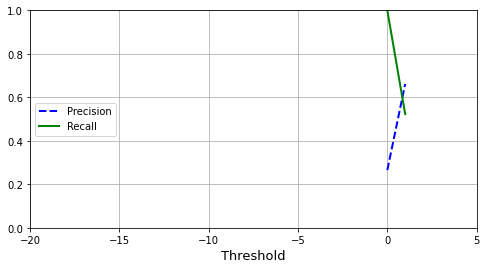

In [641]:
plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

0.6615905245346869
0.5230769230769231


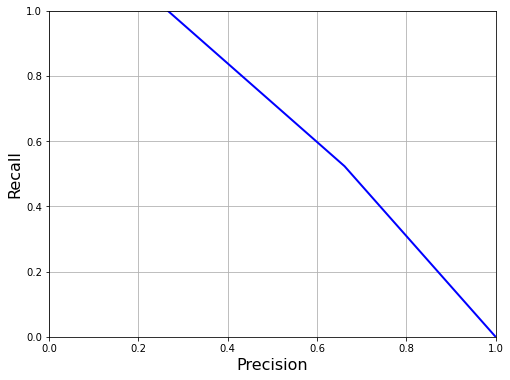

In [642]:
import matplotlib.pyplot as plt

def plot_precision_vs_recall(recalls, precisions):
    plt.plot(precisions,recalls, "b-", linewidth=2)
    plt.xlabel("Precision", fontsize=16)
    plt.ylabel("Recall", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(recalls, precisions)

threshold_80_recall = thresholds[np.argmax(recalls <= 0.80)]
threshold_80_recall

y_train_pred_80 = (y_scores >= threshold_80_recall)

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train, y_train_pred_80))
print(recall_score(y_train, y_train_pred_80))

In [709]:
print(cate_features2)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


업샘플링을 통해 GB, XGB 의 성능이 올라감.

In [ ]:
param_XGB = {"max_depth" : [3,4,5,6,7],
    "learning_rate" : [0.01, 0.05, 0.001],
    "booster" : ["gbtree","gblinear","dart"],
    "min_child_weight" : [1,3,5,7,9,11],
    "scale_pos_weight":[1,3,5]}

cv_xgb = GridSearchCV(XGBClassifier(),param_XGB, cv= 5, scoring = "roc_auc",return_train_score=True)
cv_xgb.fit(X_res, y_res)
cv_xgb_best_roc = cv_xgb.best_estimator_

print(cv_xgb.score(X_res, y_res))
print(confusion_matrix(y_res,cv_xgb.predict(X_res)))
print(classification_report(y_res,cv_xgb.predict(X_res)))

In [ ]:
param_test = {"n_estimators": range(50, 100, 25), 
              "max_depth": [1, 2, 4], 
              "learning_rate": [0.0001, 0.001, 0.01, 0.1], 
              "subsample": [0.7, 0.9], 
              "max_features": list(range(1, len(X_res), 2)), }


cv_GB = GridSearchCV(GradientBoostingClassifier(),param_test, cv= cv_mo, scoring = "roc_auc",return_train_score=True)
cv_GB.fit(X_res, y_res)
cv_GB_best_roc = cv_GB.best_estimator_

print(cv_GB.score(X_res, y_res))
print(confusion_matrix(y_res,cv_GB.predict(X_res)))
print(classification_report(y_res,cv_GB.predict(X_res)))

In [717]:
feature_importances = pd.DataFrame(cv_xgb_best_roc.fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
Contract_Month-to-month,0.551265
InternetService_Fiber optic,0.194163
Contract_Two year,0.045371
InternetService_DSL,0.028898
Contract_One year,0.025962
tenure,0.017746
MultipleLines_No phone service,0.016445
Streaming,0.012007
PaperlessBilling,0.010763
MultipleLines_No,0.010100


<AxesSubplot:xlabel='importance'>

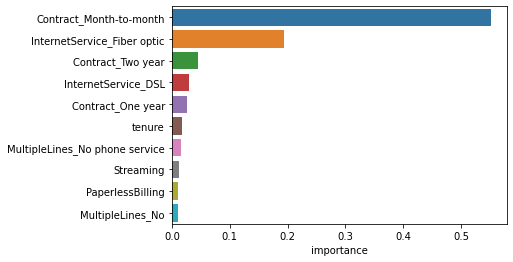

In [718]:
sns.barplot(feature_importances["importance"],feature_importances.index)

In [689]:
feature_importance = pd.DataFrame(final_model.feature_importances_,features)[0].sort_values(ascending = False)[:10]

In [695]:
feature_importance

Contract_Month-to-month        0.485180
InternetService_Fiber optic    0.146354
Contract_One year              0.055491
Contract_Two year              0.043068
PaperlessBilling               0.022978
Streaming                      0.022940
InternetService_No             0.019143
Partner                        0.018648
Dependents                     0.018337
tenure                         0.018280
Name: 0, dtype: float32

In [ ]:
# AdaBoost 확인 
model_Ada = AdaBoostClassifier(base_estimator = cv_RF_best, n_estimators = 4)
model_Ada.fit(X_prepared, y_train)
print(confusion_matrix(y_train,model_Ada.predict(X_prepared)))
print(classification_report(y_train,model_Ada.predict(X_prepared)))

In [703]:
feature_importances = pd.DataFrame(model_Ada.fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
tenure,0.217597
MonthlyChages,0.163110
Contract_Month-to-month,0.116036
SupplementaryService,0.072064
Contract_Two year,0.054757
Streaming,0.035295
InternetService_Fiber optic,0.035126
PaymentMethod_Electronic check,0.033941
PaperlessBilling,0.031797
InternetService_No,0.028371


<AxesSubplot:xlabel='importance'>

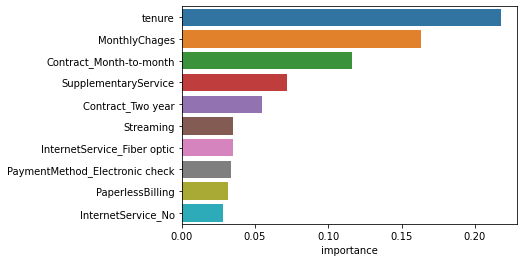

In [704]:
sns.barplot(feature_importances["importance"],feature_importances.index)

In [748]:
# # Save model
pickle.dump(cv_RF_best, open("best_RF_model.pickle", "wb"))
pickle.dump(cv_xgb_best_roc, open("best_xgb_model.pickle", "wb"))